# Evaluate (Aubio) Methods for Onset Detection

In [2]:
import dataset.aGPTset.ExpressiveGuitarTechniquesDataset as agptset
import os
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
from scipy.stats import gaussian_kde
import librosa
import aubio
import mir_eval
import random

import am24utils

dataset = agptset.import_db()

DOTEST = False
VERBOSE = False
DB_PATH = 'dataset/aGPTset'
SR = 48000
printVerbose = lambda x: print(x) if VERBOSE else None

/mnt/UNRAID/domenico/AUDIOMOSTLY-24/dataset/aGPTset/ExpressiveGuitarTechniquesDataset.py:315: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  noteLabels_df.fillna(np.nan).replace([np.nan], [None], inplace=True) # Replace NaN with None
/mnt/UNRAID/domenico/AUDIOMOSTLY-24/dataset/aGPTset/ExpressiveGuitarTechniquesDataset.py:325: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  instruments_df.fillna(np.nan).replace([np.nan], [None], inplace=True) # Replace NaN with None


In [3]:
print("Filtering the Dataset...")
filtered_notes_db, filtered_files_db = am24utils.filter_files_db(dataset)
#make sure that no audio_file_path contains "impro"
assert filtered_notes_db.index.get_level_values(1).str.contains('impro').sum() == 0, "Some audio_file_path contain 'impro' (%i)"%(filtered_notes_db.index.get_level_values(1).str.contains('impro').sum())
print("Done (%i notes in the filtered db)."%len(filtered_notes_db))


Filtering the Dataset...
Done (32592 notes in the filtered db).


In [4]:
def get_onsetlist_filename(filtered_notes_db:pd.DataFrame, filtered_files_db:pd.DataFrame):
    onsetlist_sample = []
    onsetlist_time = []
    filenames = []
    players = []
    for file in filtered_notes_db.index.get_level_values(1).unique():
        if file in filtered_files_db.index:
            afp = filtered_files_db[filtered_files_db.index == file].full_audiofile_path.values
            assert len(afp) == 1, "More than one audio file path for file %s"%file
            filenames.append(afp[0])
            cur_onset_list = filtered_notes_db.loc[filtered_notes_db.index.get_level_values(1) == file].onset_label_samples.values
            cur_onset_list = [int(x) for x in cur_onset_list]
            onsetlist_sample.append(cur_onset_list)
            onsetlist_time.append(librosa.samples_to_time(cur_onset_list, sr=SR))
            cur_player = filtered_files_db[filtered_files_db.index == file].player_id.values
            assert len(cur_player) == 1, "More than one player for file %s"%file
            cur_player = int(cur_player[0])
            players.append(cur_player)
        else:
            raise ValueError("File %s not found in the files db"%file)
        
    return onsetlist_sample, onsetlist_time, filenames, players
        



sample_onsetlist, time_onsetlist, filenames, playerlist  = get_onsetlist_filename(filtered_notes_db,filtered_files_db)
assert len(sample_onsetlist) == len(time_onsetlist) == len(filenames) == len(playerlist), "Different lengths for onsetlist, filenames and playerlist"
packedData = (time_onsetlist,filenames,playerlist)

### To Check:

Usando **aubio** ho ottenuto il seguente errore con alcuni file
```
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
Cell In[60], line 4
      2 for method in AUBIO_ONSET_METHODS:
      3     print("Computing onsets using %s method..."%method)
----> 4     detected_onsets[method] = compute_onsets(packedData, method=method)
      5     print("Done.")

Cell In[59], line 6
      4 detected_onsets = []
      5 for i, filename in enumerate(filenames):
----> 6     onsets = detect_onsets(os.path.join(DB_PATH,filename), method=method, sr=SR)
      7     detected_onsets.append(onsets)
      8     if DOTEST:

Cell In[56], line 9
      7 hop_size = 256
      8 win_size = 512
----> 9 s = aubio.source(filename, samplerate, hop_size)
     11 # Select the onset detection method
     12 if method in AUBIO_ONSET_METHODS:

RuntimeError: AUBIO ERROR: source_wavread: Failed opening dataset/aGPTset/data/audio/acoustic_guitar_percussive_thumb_mf_DomSte_20200922_additional-500.wav (not encoded with PCM)
```

In [5]:
# check if all files are PCM
import wave
import soundfile as sf

def wave_is_pcm_encoded(filename):
    try:
        with wave.open(filename, 'rb') as wf:
            # Check if the file has PCM encoding
            return wf.getcomptype() == 'NONE' and wf.getsampwidth() != 0
    except wave.Error:
        # Failed to open the file or it's not a WAV file
        return False
    
    
############################################################################
# Check if the file is PCM encoded using wave
print(20*"=","Checking if the files are PCM encoded using wave...")
pcm_files = 0
non_pcm_files = 0
list_non_pcm_files = []
for filename in filenames:
    if wave_is_pcm_encoded(os.path.join(DB_PATH,filename)):
        pcm_files += 1
    else:
        non_pcm_files += 1
        list_non_pcm_files.append(filename)
        
print("Total file analyzed", pcm_files+non_pcm_files)
# Percetange of non-PCM files and PCM files
print("Percentage of PCM files: %f"%(pcm_files/(pcm_files+non_pcm_files)*100))
print("Percentage of non-PCM files: %f"%(non_pcm_files/(pcm_files+non_pcm_files)*100))

# Print the non-PCM files
print(f"Non PCM files: {len(list_non_pcm_files)}")
for file in list_non_pcm_files:
    printVerbose(file)

print(20*"=","Done.")
############################################################################
    

def sf_is_pcm_encoded(filename):
    try:
        # Read the audio data
        audio_data, _ = sf.read(filename)

        # Check the data type of the audio data
        data_type = audio_data.dtype

        # PCM files typically have data types like 'int16' or 'int32'
        if 'int' in str(data_type):
            #print(f"{filename} is encoded with PCM: {data_type}")
            return True
        else:
            #print(f"{filename} is not encoded with PCM: {data_type}")
            return False
    except Exception as e:
        print(f"Failed to check encoding for {filename}: {e}")
    
    
# Check if the file is PCM encoded using soundfile
print(20*"=","Checking if the files are PCM encoded using soundfile...")
pcm_files = 0
non_pcm_files = 0
list_non_pcm_files = []
for filename in filenames:
    if sf_is_pcm_encoded(os.path.join(DB_PATH,filename)):
        pcm_files += 1
    else:
        non_pcm_files += 1
        list_non_pcm_files.append(filename)
        
print("Total file analyzed", pcm_files+non_pcm_files)
# Percetange of non-PCM files and PCM files
print("Percentage of PCM files: %f"%(pcm_files/(pcm_files+non_pcm_files)*100))
print("Percentage of non-PCM files: %f"%(non_pcm_files/(pcm_files+non_pcm_files)*100))
print(20*"=","Done.")

==================== Checking if the files are PCM encoded using wave...


Total file analyzed 809
Percentage of PCM files: 89.122373
Percentage of non-PCM files: 10.877627
Non PCM files: 88
==================== Done.
==================== Checking if the files are PCM encoded using soundfile...
Total file analyzed 809
Percentage of PCM files: 0.000000
Percentage of non-PCM files: 100.000000
==================== Done.


In [12]:
filename = "data/audio/acoustic_guitar_pitched_allstring2_naturalharmonics_f_LucTur_20200806.wav"
idx = filenames.index(filename)
sample_onset = sample_onsetlist[idx]
time_onset = time_onsetlist[idx]
print("ground truth onsets for file %s:"%filename)
print(time_onset)
print(sample_onset)

ground truth onsets for file data/audio/acoustic_guitar_pitched_allstring2_naturalharmonics_f_LucTur_20200806.wav:
[ 1.83508333  3.9130625   6.14602083  9.35225    11.4755     13.64889583
 20.07008333 22.293      24.5631875 ]
[88084, 187827, 295009, 448908, 550824, 655147, 963364, 1070064, 1179033]


## Onset Detection (AUBIO)

In [6]:
AUBIO_ONSET_METHODS = ['hfc', 'energy', 'complex', 'phase', 'specdiff', 'kl', 'mkl', 'specflux']
HOP_SIZE = 64
WIN_SIZE = 64

def detect_onsets(filename, method='default', samplerate=SR, hop_size=HOP_SIZE, win_size=WIN_SIZE):
    # Open the audio file
    s = aubio.source(filename, samplerate, hop_size)

    # Select the onset detection method
    if method in AUBIO_ONSET_METHODS:
        onset_detector = aubio.onset(method, win_size, hop_size, samplerate)
        # change the threshold
        onset_detector.set_threshold(0.9) 
        onset_detector.set_silence(-51.7) 
    else:
        print(f"Invalid onset detection method: {method}")
        return None

    onsets = []
    while True:
        samples, read = s()
        if onset_detector(samples):
            # Get the timestamp of the detected onset
            timestamp = onset_detector.get_last_s()
            onsets.append(timestamp)
        if read < hop_size:  # end of file reached
            break

    return onsets

In [7]:
# PCM file
print("Trying to detect onsets in PCM file...")
filename = "pcm_file_test.wav"
try:
    onsets = detect_onsets(filename, method='hfc', samplerate=SR)
except Exception as e:
    print(e)
    onsets = None
print("Done...")

# NON-PCM file
print("Trying to detect onsets in NON-PCM file...")
filename = "non_pcm_file_test.wav"
try:   
    onsets = detect_onsets(filename, method='hfc', samplerate=SR)
except Exception as e:
    print(e)
    onsets = None
    


Trying to detect onsets in PCM file...
Done...
Trying to detect onsets in NON-PCM file...
AUBIO ERROR: source_wavread: Failed opening non_pcm_file_test.wav (not encoded with PCM)


In [8]:
# Plot waveform, groundtruth onsets and detected onsets
def plot_onsets(filename, groundtruth_onset, detected_onsets, method):
    y, sr = librosa.load(filename, sr=None)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y=y, sr=sr, color='blue')
    plt.vlines(groundtruth_onset, -0.5, 0.5, color='g', linestyle='--', label='Ground truth onsets')
    # Plot detected onsets as crosses 
    plt.scatter(detected_onsets, np.zeros_like(detected_onsets), color='r', marker='x', label='Detected onsets')
    plt.legend()
    plt.title("Onset detection using %s method" % method)
    plt.show()

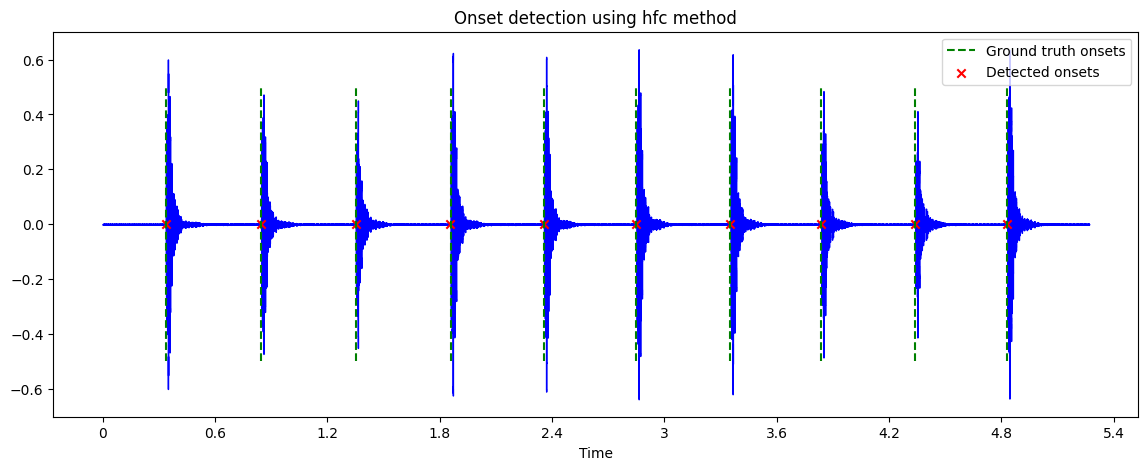

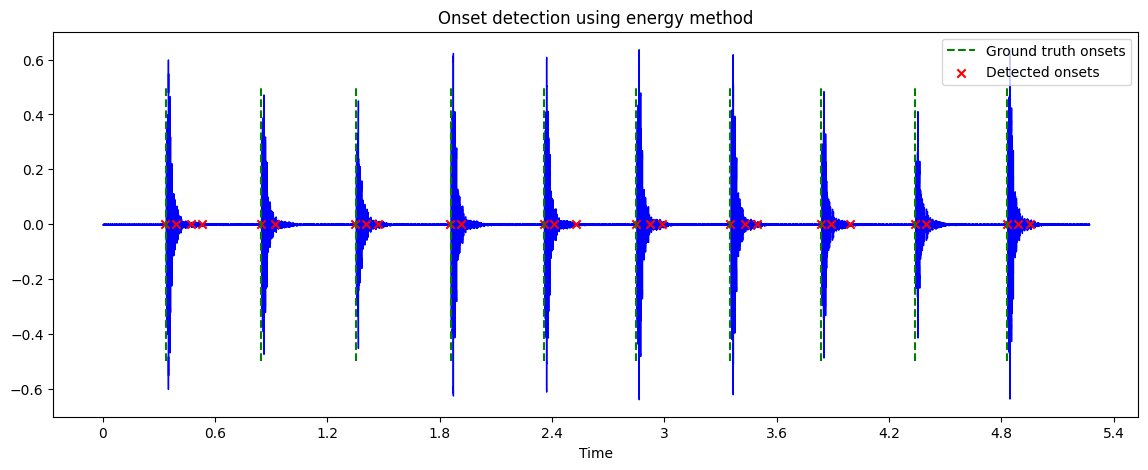

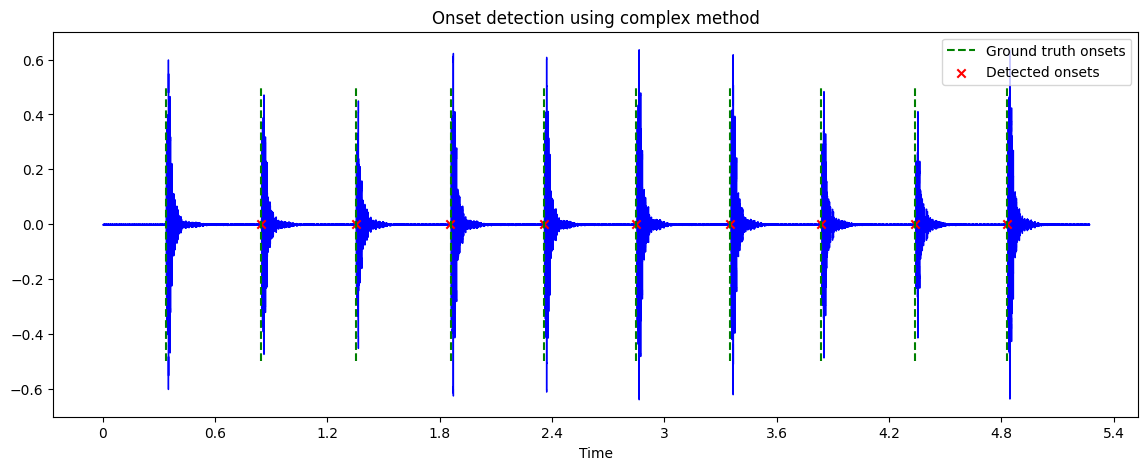

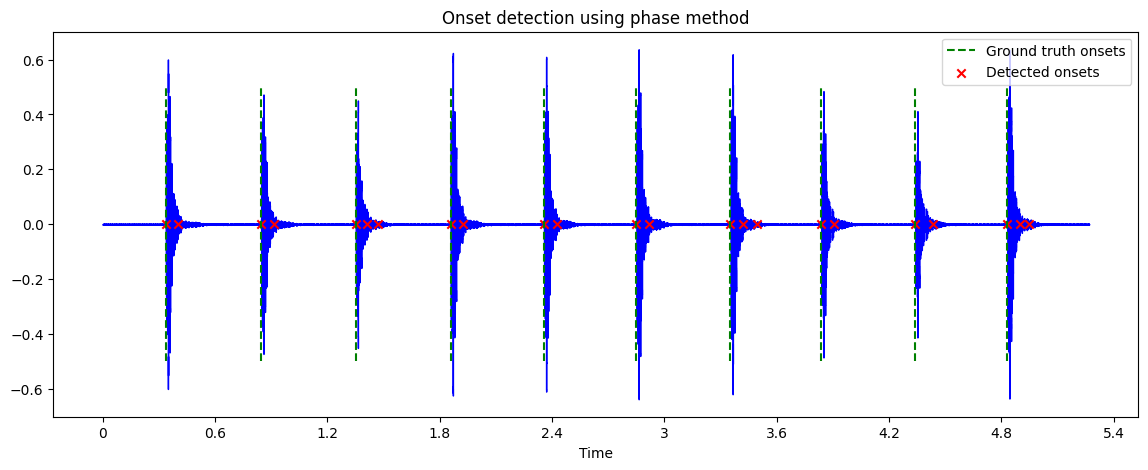

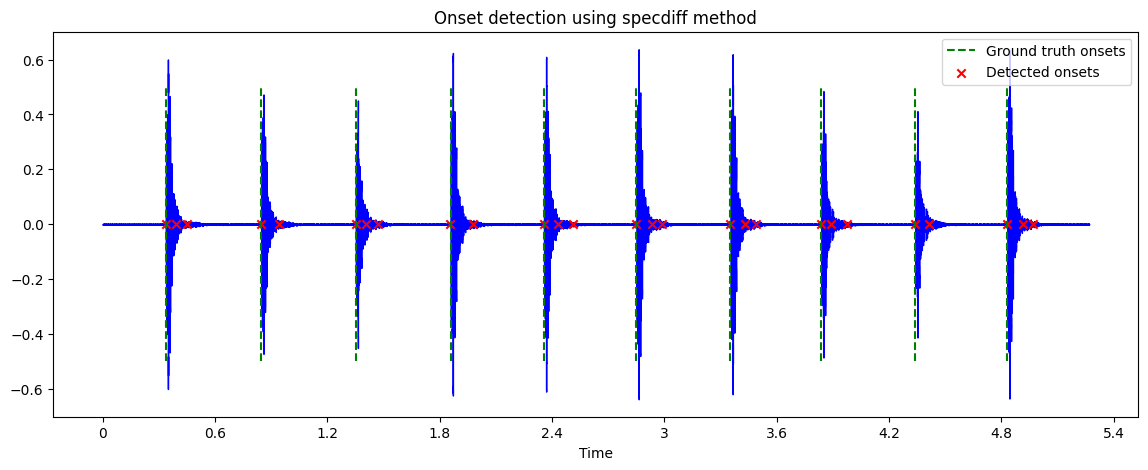

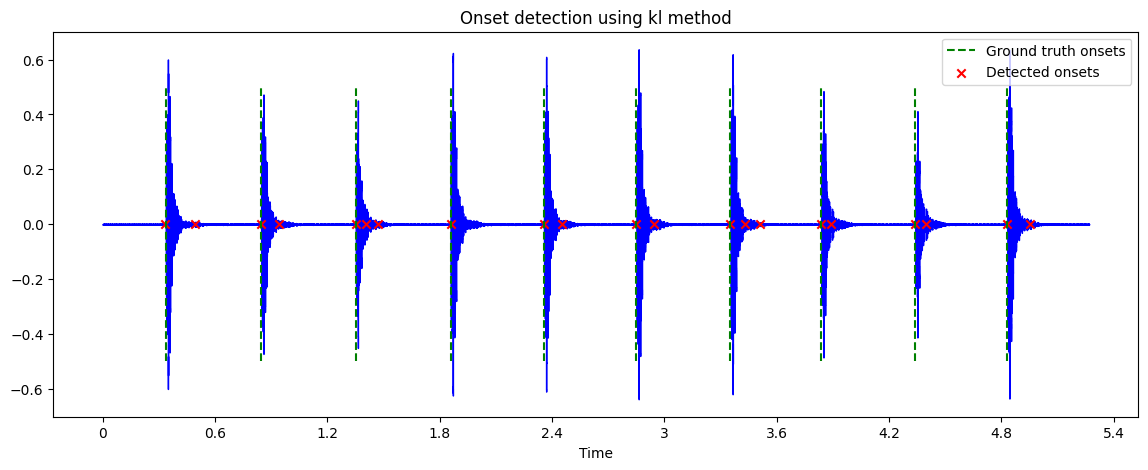

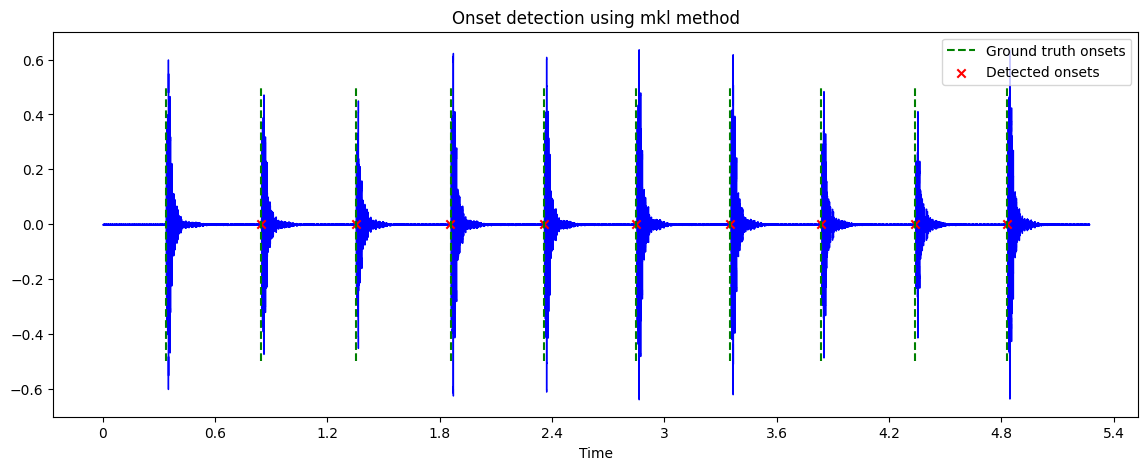

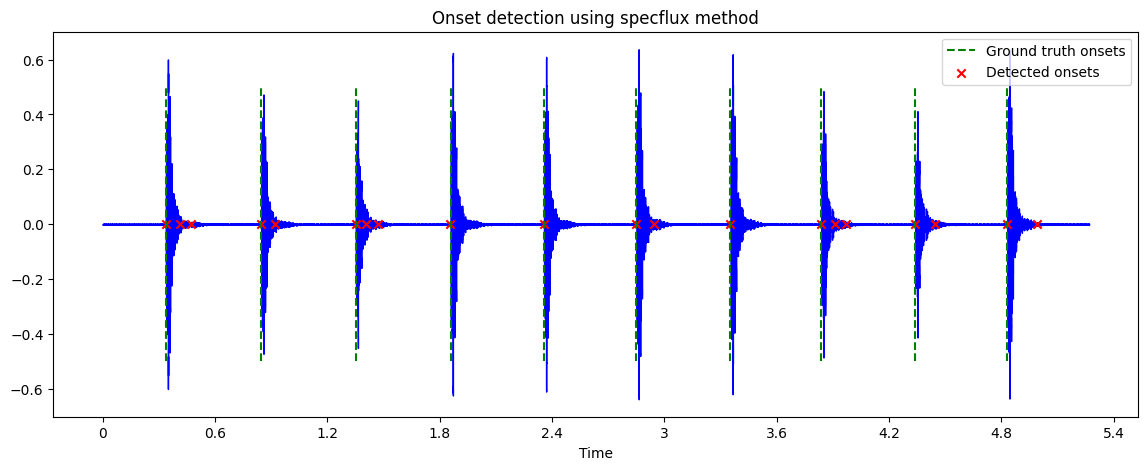

In [9]:
# Example of plotting the waveform, groundtruth onsets and detected onsets
while True:
    filename = random.choice(filenames)
    if wave_is_pcm_encoded(os.path.join(DB_PATH,filename)):
        break
groundtruth_onset = time_onsetlist[filenames.index(filename)]
for method in AUBIO_ONSET_METHODS:
    detected_onsets = detect_onsets(os.path.join(DB_PATH, filename), method=method, samplerate=48000)
    plot_onsets(os.path.join(DB_PATH, filename), groundtruth_onset, detected_onsets, method)

In [10]:
# Compute onset times using different aubio methods
def compute_onset_list(packedData, method='default'):
    print("Computing onsets using %s method..."%method)
    time_onsetlist, filenames, playerlist = packedData
    detected_onsets = []
    ground_truth_onsets = []
    for i, filename in enumerate(filenames):
        if wave_is_pcm_encoded(os.path.join(DB_PATH,filename)):
            onsets = detect_onsets(os.path.join(DB_PATH,filename), method=method, samplerate=SR)
            detected_onsets.append(onsets)
            ground_truth_onsets.append(time_onsetlist[i])
    print("Done.")
    return ground_truth_onsets, detected_onsets

In [13]:
# Compute onset times using different aubio methods (Function to be used in parallel processing)
def compute_onset(time_onset, filename, method='default'):
    ground_truth_onsets = []
    detected_onsets = []
    if wave_is_pcm_encoded(os.path.join(DB_PATH,filename)):
        onsets = detect_onsets(os.path.join(DB_PATH,filename), method=method, samplerate=SR)
        detected_onsets.extend(onsets)
        ground_truth_onsets.extend(time_onset)
    print(".", end="", flush=True)
    return ground_truth_onsets, detected_onsets

In [15]:
results = {}

for method in AUBIO_ONSET_METHODS:
    # results[method] = compute_onset_list(packedData, method=method)
    
    # Parallelize the computation
    print("Computing onsets using %s method..."%method)
    pool = mp.Pool(mp.cpu_count())
  
    result = [pool.apply_async(compute_onset, args=(time_onset, filename, method)) for time_onset, filename in zip(time_onsetlist, filenames)]
    pool.close()
    pool.join()
    
    detected_onsets = []
    ground_truth_onsets = []
    for r in result:
        ground, detected = r.get()
        if ground and detected:
            ground_truth_onsets.append(ground)
            detected_onsets.append(detected)
    
    results[method] = (ground_truth_onsets, detected_onsets)
    print("Done.")

Computing onsets using hfc method...
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Done.
Computing onsets using energy method...
............................................................................................................

# Evaluating Onset Methods

In [26]:
# Window size for onset evaluation
WINDOW = 0.025

# Calculate the error between ground truth and detected onsets
def onset_evaluation(groundtruth_onsets, detected_onsets, window=WINDOW):
    # Compute the onset error using mir_eval
    groundtruth_onsets = np.array(groundtruth_onsets)
    detected_onsets = np.array(detected_onsets)
    error = mir_eval.onset.evaluate(groundtruth_onsets, detected_onsets, window=window)
    return error
    

In [22]:
# Calculate the onset delay for a particular method depending of the hop_size and sample rate
def onset_delay(method, hop_size=HOP_SIZE, sr=SR):
    if method == "complex":
        return 4.6*hop_size/sr
    else:
        return 4.3*hop_size/sr 


# Find the closest element in detected_onset inside the range(groundtruth_onset-window1, groundtruth_onsets+window2)
def find_closest_element(groundtruth_onset, detected_onsets, window1, window2):
    # Find the closest element of detected_onsets inside range [groundtruth_onsets[i]-window1, groundtruth_onsets[i]+window2]
    # where window1 = groundtruth_onset[i] - groundtruth[i-1] and window2 = groundtruth_onset[i+1] - groundtruth[i]
    # If there is no detected_onset inside the range, return None
    detected_onsets = np.array(detected_onsets)
    detected_onsets = detected_onsets[(detected_onsets >= groundtruth_onset-window1) & (detected_onsets <= groundtruth_onset+window2)]
    if len(detected_onsets) == 0:
        return None, None
    closest_element = detected_onsets[np.argmin(np.abs(groundtruth_onset - detected_onsets))]
    error = closest_element - groundtruth_onset
    return closest_element, error
    

# Calculate the error between ground truth and detected onsets
def onset_error(groundtruth_onsets, detected_onsets, onset_delay=0.05):
    # Compute the onset error using mir_eval
    groundtruth_onsets = np.array(groundtruth_onsets)
    detected_onsets = np.array(detected_onsets)
    
    # For each element of groundtruth_onsets, find the closest element in detected_onsets and calculate the errors
    errors = []
    for i in range(len(groundtruth_onsets)):
        # Find the closest element of detected_onsets inside range [groundtruth_onsets[i]-window1, groundtruth_onsets[i]+window2]
        # where window1 = groundtruth_onset[i] - groundtruth[i-1] and window2 = groundtruth_onset[i+1] - groundtruth[i]
        if i == 0:
            window1 = 0
        else:
            window1 = onset_delay
        
        if i == len(groundtruth_onsets)-1:
            window2 = 0
        else:
            window2 = 0.1*(groundtruth_onsets[i+1] - groundtruth_onsets[i])
            
        closest_element, error = find_closest_element(groundtruth_onsets[i], detected_onsets, window1, window2)
        if error is not None and np.abs(error) <= 0.05:
            errors.append(error)
    return np.mean(np.abs(errors)), errors
        
    

In [27]:
# def onset_error(groundtruth_onsets, detected_onsets, onset_delay=24.5):
#     # Compute the onset error using mir_eval
#     groundtruth_onsets = np.array(groundtruth_onsets)
#     detected_onsets = np.array(detected_onsets)
    
#     # For each element of groundtruth_onsets, find the closest element in detected_onsets
#     # and calculate the error
#     errors = []
#     for i, onset in enumerate(groundtruth_onsets):
#         # For onset in groundtruth_onsets, find the closest onset in detected_onsets, which is the range groundtruth_onsets[i]- and groundtruth_onsets[i]+onset_delay
#         closest_onset = min(detected_onsets, key=lambda x: abs(x-onset))
#         # Calculate the error
#         error = closest_onset-onset
#         if i == 0:
#             errors.append(error)
#         else:
#             if (np.abs(error) < 0.5*(onset - groundtruth_onsets[i-1])):
#                 errors.append(error)
                
#     return np.mean(np.abs(errors)), errors

In [28]:
# For each method calculate the error between ground truth and detected onsets
method_errors = {}
method_mae = {}
method_metrics = {}
for method in AUBIO_ONSET_METHODS:
    print("Calculating error for method: %s"%method)
    print(method, "- onset_delay: %.2f [ms]"%(onset_delay(method)*1000))
    method_errors[method] = []
    method_metrics[method] = {}
    ground_truth_onsets, detected_onsets = results[method]
    for cur_ground, cur_detected in zip(ground_truth_onsets, detected_onsets):
        mae, error = onset_error(cur_ground, cur_detected, onset_delay=onset_delay(method))
        method_errors[method].append(error)
        # Calculate evaluation metrics 
        metrics = onset_evaluation(cur_ground, cur_detected)
        method_metrics[method].update(metrics)
        
    # Calculaxte the mean error for the method
    method_mae[method] = np.mean(np.abs(np.concatenate(method_errors[method])))
    print('+-------------------------------------+')        
    print("Mean Absolute Error %.2f [ms]"%(method_mae[method]*1000))    
    # Calculate the mean evaluation metrics
    for key in method_metrics[method].keys():
        method_metrics[method][key] = np.mean(method_metrics[method][key])
    
    print('+-------------------------------------+')        
    print('| Precision: %f'%metrics['Precision'])
    
    print('| Recall: %f'%metrics['Recall'])
    print('| F-measure: %f'%metrics['F-measure'])
    print('+-------------------------------------+')        
    print("\n")

Calculating error for method: hfc
hfc - onset_delay: 5.73 [ms]
+-------------------------------------+
Mean Absolute Error 1.36 [ms]
+-------------------------------------+
| Precision: 0.984127
| Recall: 0.984127
| F-measure: 0.984127
+-------------------------------------+


Calculating error for method: energy
energy - onset_delay: 5.73 [ms]
+-------------------------------------+
Mean Absolute Error 3.91 [ms]
+-------------------------------------+
| Precision: 0.094617
| Recall: 0.920635
| F-measure: 0.171598
+-------------------------------------+


Calculating error for method: complex
complex - onset_delay: 6.13 [ms]
+-------------------------------------+
Mean Absolute Error 1.48 [ms]
+-------------------------------------+
| Precision: 0.750000
| Recall: 0.190476
| F-measure: 0.303797
+-------------------------------------+


Calculating error for method: phase
phase - onset_delay: 5.73 [ms]
+-------------------------------------+
Mean Absolute Error 2.58 [ms]
+--------------

In [ ]:
import os
RESFOLDER = 'results/onset_detection_PDFs'
os.makedirs(RESFOLDER, exist_ok=True)

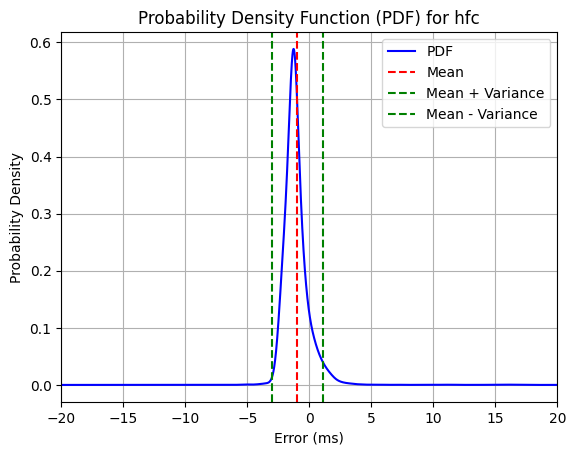

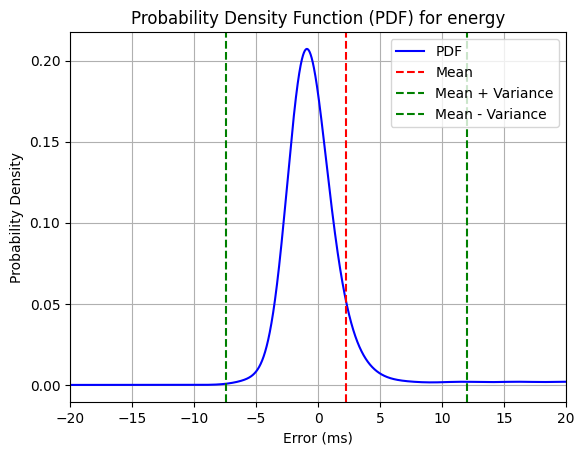

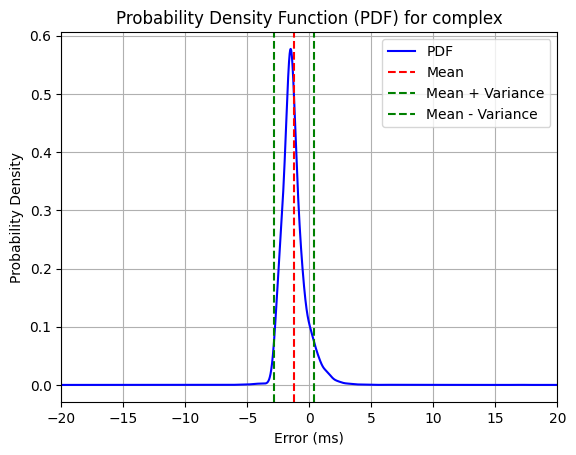

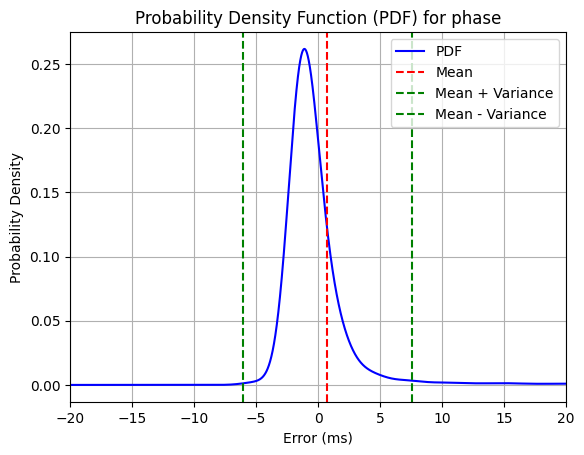

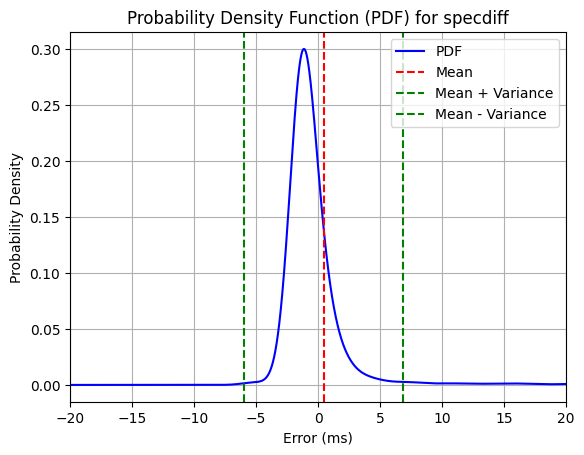

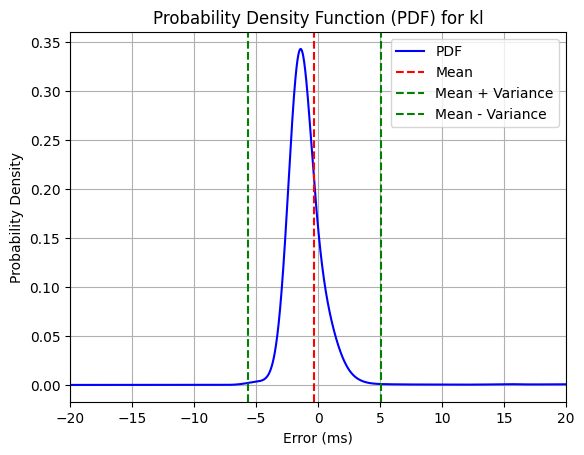

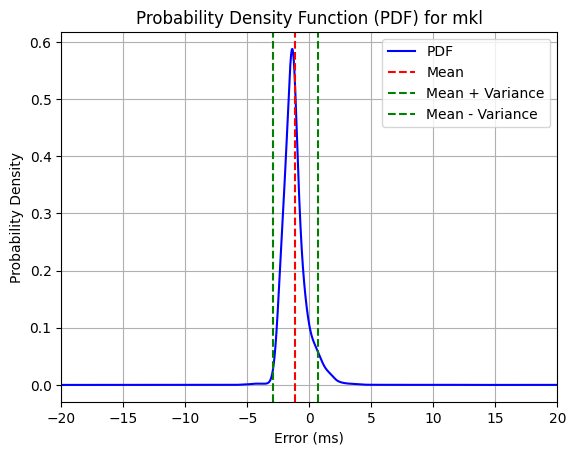

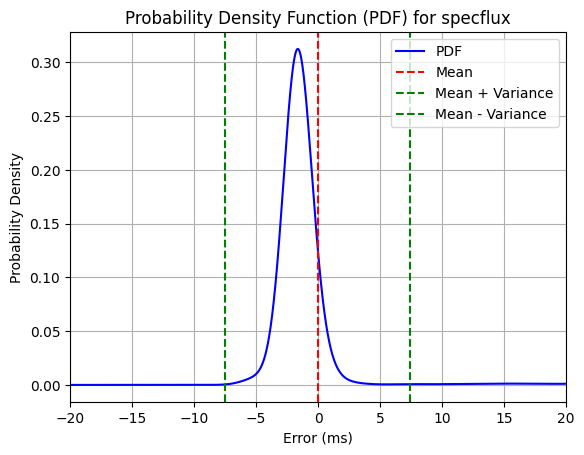

In [ ]:
# Estimate the probability distribution function for each method
PLOT_TIME_IN_MS = True #Else is in seconds
import copy

def plot_error_distribution(errors_s, method):
    # Estimate the probability density function
    if PLOT_TIME_IN_MS:
        errors = np.array(errors_s)*1000

    # minmax_time = 50 if PLOT_TIME_IN_MS else 0.05
    minmax_time = 10 if PLOT_TIME_IN_MS else 0.01

    kde = gaussian_kde(errors)
    x = np.linspace(-1*minmax_time, minmax_time, 10000)
    # Compute the unnormalized PDF
    pdf = kde(x)
    
    # Compute mean and variance of the data
    mean_error = np.mean(errors)
    variance_error = np.var(errors)

    plt.clf()
    # Plot the PDF
    plt.plot(x, pdf, label='PDF', color='b')

        # Plot mean and variance as vertical lines
    plt.axvline(x=mean_error, color='r', linestyle='--', label='Mean')
    plt.axvline(x=mean_error + np.sqrt(variance_error), color='g', linestyle='--', label='Mean + Variance')
    plt.axvline(x=mean_error - np.sqrt(variance_error), color='g', linestyle='--', label='Mean - Variance')

    plt.title('Probability Density Function (PDF) for %s'%method)
    plt.xlabel('Error (%s)'%('ms' if PLOT_TIME_IN_MS else 's'))
    plt.ylabel('Probability Density')
    plt.xlim(-1*minmax_time, minmax_time)
    plt.legend()
    plt.grid(True)
    plt.show()
    #plt.savefig(os.path.join(RESFOLDER, 'PDF_%s.pdf'%method))
    #plt.clf()

    return (mean_error, variance_error, np.sqrt(variance_error), np.percentile(errors, 75) - np.percentile(errors, 25))

# Mean, variance, sd, iqr all in a pd.dataframe
statistics = pd.DataFrame(columns=['mean', 'variance', 'sd', 'iqr'])
for method in AUBIO_ONSET_METHODS:
    statistics_tpl = plot_error_distribution(np.concatenate(method_errors[method], axis=None), method)
    #Add tuple as row in dataframe and add index
    statistics.loc[method] = statistics_tpl
    minmax_time = 50 if PLOT_TIME_IN_MS else 0.05
    # plot_histogram(np.concatenate(method_errors[method], axis=None), method)

In [ ]:
for method in AUBIO_ONSET_METHODS:
    print("statistics in [ms] for method: %s"%method)
    print('+-------------------------------------+')        
    print(statistics.loc[method])
    print('+-------------------------------------+')        
    print("\n")

statistics in [ms] for method: hfc
+-------------------------------------+
mean       -0.962538
variance    4.261059
sd          2.064233
iqr         0.895177
Name: hfc, dtype: float64
+-------------------------------------+


statistics in [ms] for method: energy
+-------------------------------------+
mean         2.278436
variance    94.865355
sd           9.739885
iqr          1.916354
Name: energy, dtype: float64
+-------------------------------------+


statistics in [ms] for method: complex
+-------------------------------------+
mean       -1.225426
variance    2.694809
sd          1.641587
iqr         0.978896
Name: complex, dtype: float64
+-------------------------------------+


statistics in [ms] for method: phase
+-------------------------------------+
mean         0.763565
variance    46.904621
sd           6.848695
iqr          1.705760
Name: phase, dtype: float64
+-------------------------------------+


statistics in [ms] for method: specdiff
+-------------------------

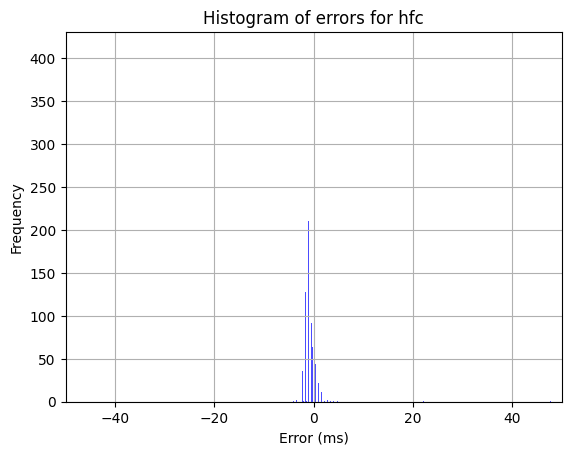

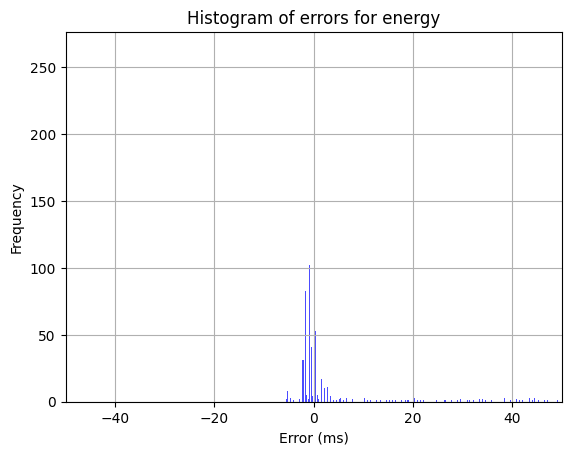

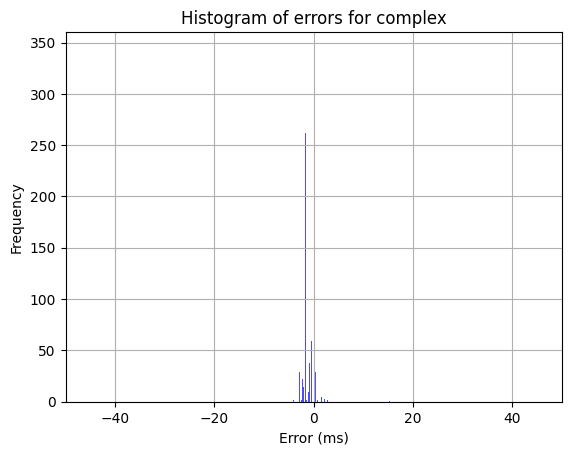

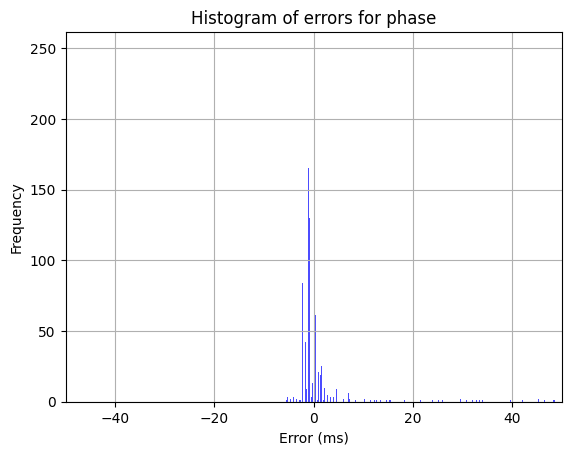

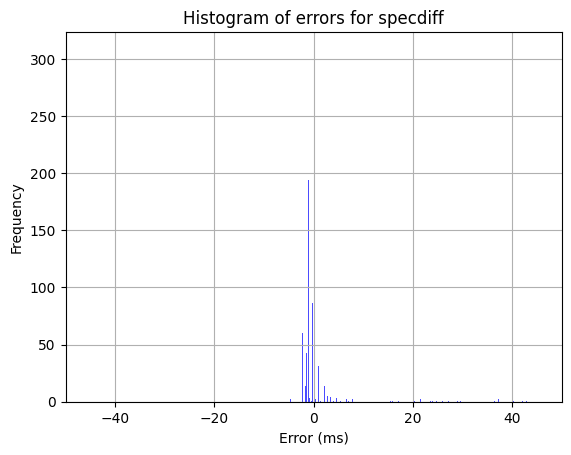

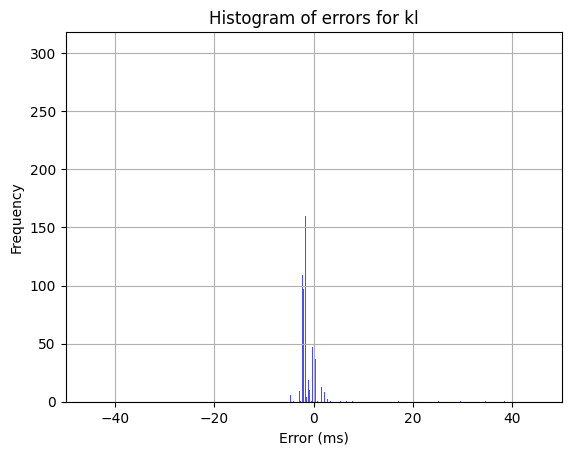

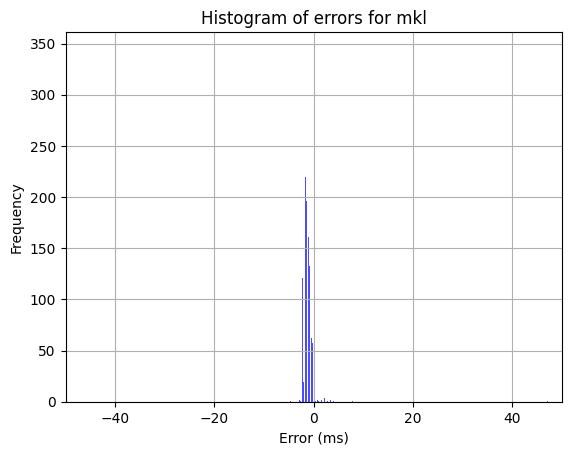

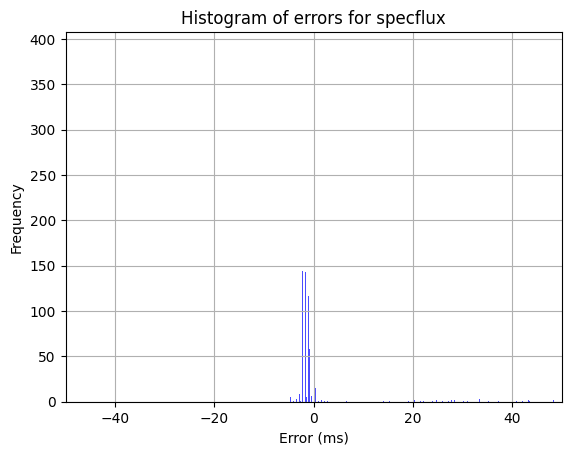

In [ ]:
def plot_histogram(errors_s, method):
    if PLOT_TIME_IN_MS:
        errors = np.array(errors_s)*1000
    plt.hist(errors, bins=10000, color='b', alpha=0.7)
    plt.title('Histogram of errors for %s'%method)
    plt.xlabel('Error (%s)'%('ms' if PLOT_TIME_IN_MS else 's'))
    plt.ylabel('Frequency')
    plt.xlim(-1*minmax_time, minmax_time)
    plt.grid(True)
    plt.show()
    #plt.savefig(os.path.join(RESFOLDER, 'PDF_hist_%s.png'%method))
    
for method in AUBIO_ONSET_METHODS:
    plot_histogram(np.concatenate(method_errors[method], axis=None), method)

In [ ]:
# stat_tex_table = statistics.to_latex(float_format="%.0f", 
#                                     caption="Statistics of the onset detection error for each aubio method. Error is measured in Milliseconds", 
#                                     bold_rows=True,
#                                     label="tab:aubio_onset_statistics")

# LATEX_HEADER = r"""
# \documentclass{article}
# \usepackage{booktabs}
# \usepackage{graphicx} % Required for inserting images

# \title{AudioMostly24-Appendix}
# \author{Gregorio Andrea Giudici}
# \author{Domenico Stefani}
# \date{April 2024}

# \begin{document}

# \maketitle
# """
# LATEX_FOOTER = r"""\end{document}"""

# with open(os.path.join(RESFOLDER, 'appendix.tex'),"w") as ftexa:
#     printf = lambda x: print(x, file=ftexa)
#     printf(LATEX_HEADER)
#     printf(stat_tex_table.replace(r'\begin{table}','\\begin{table}\n\\centering'))
#     printf("\\section{Onset Detection Latency (Aubio)}")
#     printf('\n\\subsection{Parameters}\n')
#     printf("The following parameters were used for the onset detection:")
#     printf("\\begin{itemize}")
#     printf("\\item Sampling Rate: %i"%SR)
#     printf("\\item Hop Size: %i"%HOP_SIZE)
#     printf("\\item Window Size: %i"%WIN_SIZE)
#     printf("\\end{itemize}")
#     printf('\n\\subsection{Statistics}\n')
#     printf('Statistics in Table \\ref{tab:aubio_onset_statistics}.')
#     printf('\n\\subsection{PDF plots}\n')
#     for method in AUBIO_ONSET_METHODS:
#         printf("")
#         printf("\\begin{figure}[htb]")
#         printf("    \\centering")
#         printf("    \\includegraphics[width=0.9\\textwidth]{PDF_%s.pdf}"%method)
#         printf("    \\caption{Probability Density Function for %s}"%method)
#         printf("\\end{figure}")
#         printf("")
#     printf(LATEX_FOOTER)

# #os.system("pdflatex -output-directory=%s %s"%(RESFOLDER, os.path.join(RESFOLDER, 'appendix.tex')))